<a href="https://colab.research.google.com/github/vpw/TSAI-END3/blob/main/Assignment7/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2021-12-18 13:00:26--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.160.89, 13.224.160.7, 13.224.160.39, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.160.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2021-12-18 13:00:27 (25.5 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Ita

In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis seulement fatiguee .', 'i m just tired .']


In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [13]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Function to get a sample of the actual target and the predicted output for n random samples.

In [85]:
def getTgtPred(encoder, decoder, n=1000):
  tgt, pred = [], []
  for i in range(n):
    pair = random.choice(pairs)
    output_words, attentions = evaluate(encoder, decoder, pair[0])
    output_sentence = ' '.join(output_words[:-1])
    
    tgt.append(pair[1])
    pred.append(output_sentence)
  
  #print(f"Len tgt {len(tgt)}, Len pred {len(pred)}")
  #print(pred[:5], '\n', tgt[:5])
    
  return tgt, pred

#tgt, pred = getOutPred(encoder1, attn_decoder1)

To get precision, recall and f-score I am using the function precision_recall_fscore_support from sklearn. Computing the y_true and y_pred needed for this function. y_true and y_pred must match when the target matches the precidted value, in this case I am using a simple == to match the output sentences (I could have used a different similarity metric instead as well (I think)!)

In [162]:
from sklearn.metrics import precision_recall_fscore_support

def getYtrueYpred(tgt, pred):
  y_true, y_pred = [], []
  for t, p in zip(tgt, pred):
    posneg = random.randint(0,1)
    y_true.append(posneg)
    if (t==p):
      y_pred.append(posneg)
    else:
      y_pred.append(1-posneg)

  return y_true, y_pred

#y_true, y_pred = getYtrueYpred(out,pred) 
#print(precision_recall_fscore_support(y_true,y_pred, average='micro', zero_division=0))

For the BLEU score I am using torchtext bleu_score which needs the candidate and reference corpii, which is computed first.

In [37]:
from torchtext.data.metrics import bleu_score

def prepareBLEUCorpus(tgt, pred):
  candidate_corpus, reference_corpus = [], []
  for r, c in zip(tgt, pred):
    candidate_corpus.append(c.split(' '))
    reference_corpus.append([r.split(' ')])
  return candidate_corpus, reference_corpus
#candidate_corpus, reference_corpus = prepareBLEUCorpus(out, pred)
#print(bleu_score(candidate_corpus, reference_corpus))

BERT score is taken based on the reference given in the tutorial session.

In [18]:
#https://github.com/Tiiiger/bert_score/blob/master/example/Demo.ipynb
# https://github.com/Tiiiger/bert_score/blob/master/bert_score/scorer.py

!pip install bert-score

     |████████████████████████████████| 60 kB 3.0 MB/s 
     |████████████████████████████████| 3.4 MB 8.8 MB/s 
     |████████████████████████████████| 3.3 MB 40.9 MB/s 
     |████████████████████████████████| 596 kB 40.8 MB/s 
     |████████████████████████████████| 61 kB 539 kB/s 
     |████████████████████████████████| 895 kB 42.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [19]:
from bert_score import BERTScorer
bert_scorer = BERTScorer(lang="en", rescale_with_baseline=True)
from torch import mean

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
def getBERTHypsRefs(tgt, pred):
  hyps, refs = [], []

  for r, h in zip(tgt, pred):
    hyps.append(h)
    refs.append([r])

  return hyps, refs

#hyps, refs = getBERTRefsHyps(out, pred)
#P, R, F1 = bert_scorer.score(hyps, refs)
#print(p, r, f1)
#print(mean(p), mean(r), mean(f1))


In [21]:
# perplexity

import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
# perplexity
# generate the unigram & bigram probabilities from the target corpus

from nltk.probability import FreqDist, ProbDistI, ConditionalFreqDist, ConditionalProbDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import ngrams

def getUnigramProbs(tgt):

  tok_sent = [word_tokenize(s) for s in tgt]

  # unigrams
  # frequency distribution
  freq_1gram = FreqDist()
  n_words = 0
  for tok in tok_sent:
    #print (s)
    n_words += len(tok)
    for word in tok:
      freq_1gram[word] += 1

  # probability distribution
  #def unigram_prob(word):
  #  return freq_1gram[word]/n_words

  prob_1gram = nltk.probability.DictionaryProbDist(dict(freq_1gram), normalize=True)

  return freq_1gram, prob_1gram

def getBigramProbs(tgt):
  # bigrams
  # append with SOS to get the first bigram
  for i in range(len(tgt)):
    tgt[i] = "SOS "+ tgt[i]

  tok_sents = [word_tokenize(sentence) for sentence in tgt]

  # frequency distribution
  freq_2gram = ConditionalFreqDist()
  for tok_sent in tok_sents:
    bigrams = ngrams(tok_sent,2)
    for bg in bigrams:
      #print(bg)
      freq_2gram[bg[0]][bg[1]] += 1

  # probability distribution
  prob_2gram = ConditionalProbDist(freq_2gram, nltk.MLEProbDist)
  return freq_2gram, prob_2gram

In [23]:
MIN_PROB = 0.00001 # in case the word or bigram is not seen in the corpus, keep a low value of probability instead of 0

def getUnigramPerplexity(sentence, prob_1gram):
  logP = 0
  tok_sent = word_tokenize(sentence)
  for w in tok_sent:
    p = prob_1gram.prob(w)
    p = p or MIN_PROB
    logP += math.log(p,2)
  pp = math.pow(2,-1.*logP/len(sentence))
  return pp

def getBigramPerplexity(sentence, prob_2gram, SOS_present=False):
  logP = 0
  if not SOS_present:
    sentence = "SOS "+sentence
  tok_sent = word_tokenize(sentence)
  bigrams = ngrams(tok_sent,2)

  for bg in bigrams:
    p = prob_2gram[bg[0]].prob(bg[1])
    p = p or MIN_PROB
    logP += math.log(p,2)

  pp = math.pow(2,-1.*logP/len(sentence))
  return pp

In [59]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [155]:
FS=6
def showMetrics(pdata):

    labels=[['Precision','Recall','F-score'],'BLEU', ['BERT-Prec','BERT-Rec','BERT-F1'],['Perp-UNI','Perp-BI']]
    # Precision, Recall, Fscore
    plt.figure(figsize=(FS,FS))    
    for y,label in zip(pdata[1],labels[0]):
      plt.plot(pdata[0],y,label=label)
    plt.legend()
    # BLEU
    plt.figure(figsize=(FS,FS))
    plt.plot(pdata[0],pdata[2],label=labels[1])
    plt.legend()
    # BERT - Precision, Recall, Fscore
    plt.figure(figsize=(FS,FS))    
    for y,label in zip(pdata[3],labels[2]):
      plt.plot(pdata[0],y,label=label)
    plt.legend()
    # Perplexity - UNIgram, BIgram
    plt.figure(figsize=(FS,FS))    
    for y,label in zip(pdata[4],labels[3]):
      plt.plot(pdata[0],y,label=label)
    plt.legend()
        


In [154]:
sep = "------------------------------------------------------"
def getAss7Metrics(encoder, decoder):
    tgt, pred = getTgtPred(encoder, decoder)
    # Precision, Recall, F1-score
    y_true, y_pred = getYtrueYpred(tgt,pred) 
    print(sep)
    (p,r,f,_)=precision_recall_fscore_support(y_true,y_pred, average='micro', zero_division=0)
    print(f"Precision: {p}, Recall: {r}, F-score: {f}")
    # BLEU
    candidate_corpus, reference_corpus = prepareBLEUCorpus(tgt, pred)
    print(sep)
    bleu=bleu_score(candidate_corpus, reference_corpus)
    print(f"BLEU score: {bleu}")
    # BERT
    print(sep)
    hyps, refs = getBERTHypsRefs(tgt, pred)
    P, R, F = bert_scorer.score(hyps, refs)
    #print(p, r, f1)
    (BP,BR,BF)=(P.mean().item(),R.mean().item(),F.mean().item())
    print(f"BERT Precision (avg): {BP}, BERT Recall: {BR}, BERT F-score: {BF}")
    #print(mean(P), mean(R), mean(F1))
    # Perplexity
    print(sep)
    _, probs_1gram = getUnigramProbs(tgt)
    _, probs_2gram = getBigramProbs(tgt)
    nSent = len(pred)
    uniPerp, biPerp = 0., 0.
    for s in pred:
        uniPerp += getUnigramPerplexity(s, probs_1gram)
        biPerp += getBigramPerplexity(s, probs_2gram)
    uniPerp /= nSent
    biPerp /= nSent
    print (f"Avegare Unigram perplexity = {uniPerp}")
    print (f"Avegare Bigram perplexity = {biPerp}")
    print(sep)
    return [[p,r,f],bleu,[BP,BR,BF],[uniPerp,biPerp]]


In [157]:

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, eval_last=10, eval_every=1000, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    metrics_data=[[],np.empty((0,3),float),[],np.empty((0,3),float),np.empty((0,2),float)]
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()
    assert (eval_last * eval_every < n_iters/2)
    start_eval_idx = (n_iters - eval_last * eval_every)
    

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

        if iter > start_eval_idx:
            if (iter - start_eval_idx) % eval_every == 0:
                print('Eval %s (%d %d%%)' % (timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100))
                mdata = getAss7Metrics(encoder, decoder)
                metrics_data[0].append(iter)
                metrics_data[1]=np.append(metrics_data[1],[mdata[0]],axis=0)
                metrics_data[2].append(mdata[1])
                metrics_data[3]=np.append(metrics_data[3],[mdata[2]],axis=0)
                metrics_data[4]=np.append(metrics_data[4],[mdata[3]],axis=0)
                #print(metrics_data)  

    metrics_data[1]=metrics_data[1].T
    metrics_data[3]=metrics_data[3].T
    metrics_data[4]=metrics_data[4].T
    #print(metrics_data)
    showPlot(plot_losses)
    showMetrics(metrics_data)

In [28]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 54s (- 26m 43s) (5000 6%) 2.8665
3m 41s (- 24m 0s) (10000 13%) 2.2706
5m 29s (- 21m 58s) (15000 20%) 1.9987
7m 17s (- 20m 3s) (20000 26%) 1.7371
9m 8s (- 18m 16s) (25000 33%) 1.5358
10m 57s (- 16m 26s) (30000 40%) 1.3585
12m 46s (- 14m 36s) (35000 46%) 1.2061
14m 36s (- 12m 47s) (40000 53%) 1.0847
16m 25s (- 10m 57s) (45000 60%) 0.9794
18m 13s (- 9m 6s) (50000 66%) 0.8852
20m 3s (- 7m 17s) (55000 73%) 0.8181
Eval 20m 25s (- 6m 55s) (56000 74%)
------------------------------------------------------
Precision: 0.409, Recall: 0.409, F-score: 0.409
------------------------------------------------------
BLEU score: 0.6110410094261169
------------------------------------------------------
BERT Precision (avg): 0.7467592358589172, BERT Recall: 0.7450917959213257, BERT F-score: 0.7461121082305908
------------------------------------------------------
Avegare Unigram perplexity = 3.499062098008892
Avegare Bigram perplexity = 2.5272090684048614
------------------------------------------------

<Figure size 432x288 with 0 Axes>

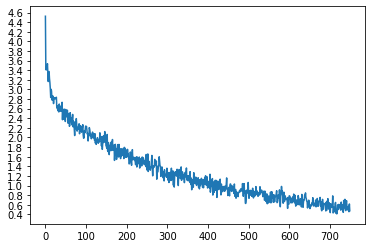

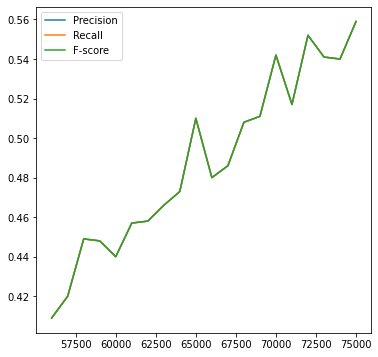

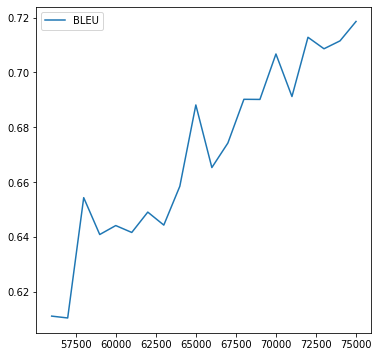

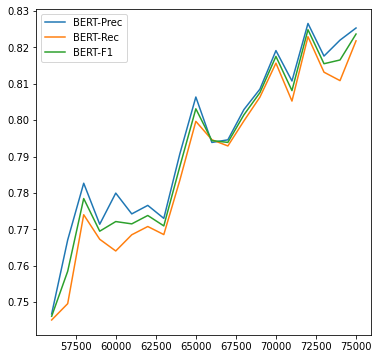

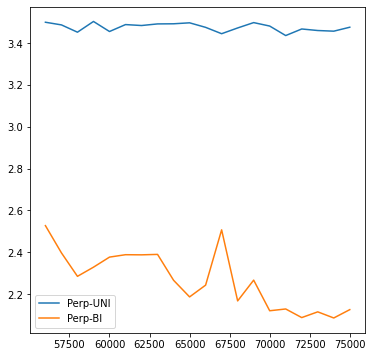

In [164]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
#trainIters(encoder1, attn_decoder1, 1000, print_every=200, eval_last=3, eval_every=100)
trainIters(encoder1, attn_decoder1, 75000, print_every=5000, eval_last=20, eval_every=1000)

In [53]:
evaluateRandomly(encoder1, attn_decoder1)

> tu es assez vieux pour savoir mieux .
= you re old enough to know better .
< you re too old for me . <EOS>

> vous etes toujours celibataire n est ce pas ?
= you re still single aren t you ?
< you re a good cook aren t you ? <EOS>

> nous sommes etudiants .
= we re students .
< we re students . <EOS>

> nous ne sommes pas vieux .
= we re not old .
< we re not old . <EOS>

> il est notre unique suspect .
= he s our only suspect .
< he is a by the . <EOS>

> tu es confus .
= you re confused .
< you re beautiful . <EOS>

> je suis mariee et j ai deux enfants .
= i am married and have two children .
< i am a and tired of two . <EOS>

> je suis depourvue de talent .
= i m untalented .
< i m untalented . <EOS>

> il est devant la porte .
= he is in front of the door .
< he is in the the the . <EOS>

> vous allez aussi me manquer .
= i m going to miss you too .
< i m going to miss you . . <EOS>



In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = elle a cinq ans de moins que moi .
output = she is five years younger than me am . <EOS>
input = elle est trop petit .
output = she s too loud . <EOS>
input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>
input = c est un jeune directeur plein de talent .
output = he s a talented young . . <EOS>


https://scikit-learn.org/stable/modules/model_evaluation.html

In [55]:
tgt = ["This is a sample sentence", "It is raining heavily today", "I wish I was in a cinema hall", "This stuff is interesting"]
_, probs_1gram = getUnigramProbs(tgt)
_, probs_2gram = getBigramProbs(tgt)

In [61]:
s = "This is a sample sentence."
print(getUnigramPerplexity(s, prob_1gram))
print(getBigramPerplexity(s, probs_2gram))

2.5642415270055112
1.631825472321649


In [60]:
prob_1gram.prob('This')

0.09090909090909091

In [30]:
#freq_2gram.conditions()
freq_2gram['This'].keys()

dict_keys(['is', 'stuff'])

In [29]:
prob_2gram['This'].prob('is')

0.5

In [4]:
import nltk
import nltk.corpus
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [ ]:
from nltk.corpus import brown

# an nltk.FreqDist() is like a dictionary,

# but it is ordered by frequency.

# Also, nltk automatically fills the dictionary

# with counts when given a list of words.

freq_brown = nltk.FreqDist(brown.words())

list(freq_brown.keys())[:20]

freq_brown.most_common(20)



In [ ]:
# an nltk.ConditionalFreqDist() counts frequencies of pairs.

# When given a list of bigrams, it maps each first word of a bigram

# to a FreqDist over the second words of the bigram.

cfreq_brown_2gram = nltk.ConditionalFreqDist(nltk.bigrams(brown.words()))

# conditions() in a ConditionalFreqDist are like keys()

# in a dictionary

cfreq_brown_2gram.conditions()

# the cfreq_brown_2gram entry for "my" is a FreqDist.

cfreq_brown_2gram["my"]

# here are the words that can follow after "my".

# We first access the FreqDist associated with "my",

# then the keys in that FreqDist

cfreq_brown_2gram["my"].keys()

# here are the 20 most frequent words to come after "my", with their frequencies

cfreq_brown_2gram["my"].most_common(20)